### Libraries

In [1]:
import glob
import os
from tqdm import tqdm
import pandas as pd

import random
import torch
import torchaudio
from torchaudio import transforms

from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

### Create dataset

In [2]:
paths = []
categories = []
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold1/*"):
    categories += [0]
    paths += [i]
categories = categories[:109]
paths = paths[:109]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold2/*"):
    categories += [1]
    paths += [i]
categories = categories[:218]
paths = paths[:218]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold3/*"):
    categories += [2]
    paths += [i]
categories = categories[:327]
paths = paths[:327]
for i in glob.glob("/kaggle/input/outube-dataset-1800/youtube_dataset_1800/fold4/*"):
    categories += [3]
    paths += [i]
categories = categories[:436]
paths = paths[:436]

In [3]:
df = pd.DataFrame({"paths":paths, "categories":categories}).sample(frac=1).reset_index(drop=True)
df

,paths,categories
0,/kaggle/input/outube-dataset-1800/youtube_data...,2
1,/kaggle/input/outube-dataset-1800/youtube_data...,2
2,/kaggle/input/outube-dataset-1800/youtube_data...,2
3,/kaggle/input/outube-dataset-1800/youtube_data...,1
4,/kaggle/input/outube-dataset-1800/youtube_data...,1
...,...,...
431,/kaggle/input/outube-dataset-1800/youtube_data...,0
432,/kaggle/input/outube-dataset-1800/youtube_data...,2
433,/kaggle/input/outube-dataset-1800/youtube_data...,1
434,/kaggle/input/outube-dataset-1800/youtube_data...,2


In [4]:
class CustomdDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 30
        self.new_freq = 16000
        self.top_db = 80
        self.n_fft = 1024
        self.n_mels = 64
            
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'paths']
        class_id = self.df.loc[idx, 'categories']

        arr, org_sr = torchaudio.load(audio_file)
        arr = torchaudio.functional.resample(arr, orig_freq=org_sr, new_freq=self.new_freq)
        org_sr =  self.new_freq


        num_rows, sig_len = arr.shape
        max_len = self.new_freq*self.duration
        if (sig_len > max_len):
            arr = arr[:,:max_len]
        elif (sig_len < max_len):
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            arr = torch.cat((pad_begin, arr, pad_end), 1)

        spec = transforms.MelSpectrogram(org_sr, n_fft=self.n_fft, hop_length=None, n_mels=self.n_mels)(arr)
        spec = transforms.AmplitudeToDB(top_db=self.top_db)(spec)
        return spec, class_id

In [5]:
from torch.utils.data import random_split

myds = CustomdDS(df)

num_train = round(len(myds) * 0.8)
num_val = len(myds) - round(len(myds) * 0.8)
train_ds, val_ds = random_split(myds, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

### Model for classification

In [6]:
class AudioClassifier (nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []

        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=4)

        self.conv = nn.Sequential(*conv_layers)
 

    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
customModel = AudioClassifier().to(device)

### Training

In [7]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(customModel.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

for epoch in range(num_epochs):
    
    customModel.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    for i, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        optimizer.zero_grad()
        outputs = customModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        _, prediction = torch.max(outputs,1)
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]


    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, train_loss: {avg_loss:.2f}, accuracy_train: {acc:.2f}')
    customModel.eval()
    
    correct_prediction = 0
    total_prediction = 0

    with torch.no_grad():
        loss_valid = 0
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = customModel(inputs)
            loss = criterion(outputs, labels)
            loss_valid += loss.item()
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction/total_prediction
    print(f'val_loss: {loss_valid/len(val_dl)}, accuracy_valid: {acc:.2f}')
    
   
print('Finished Training')

100%|██████████| 22/22 [18:23<00:00, 50.18s/it]


Epoch: 0, train_loss: 1.38, accuracy_train: 0.26
val_loss: 1.3667023380597432, accuracy_valid: 0.30


100%|██████████| 22/22 [18:22<00:00, 50.10s/it]


Epoch: 1, train_loss: 1.35, accuracy_train: 0.39
val_loss: 1.3398761351903279, accuracy_valid: 0.33


100%|██████████| 22/22 [18:24<00:00, 50.20s/it]


Epoch: 2, train_loss: 1.30, accuracy_train: 0.40
val_loss: 1.3079910278320312, accuracy_valid: 0.33


100%|██████████| 22/22 [17:57<00:00, 48.96s/it]


Epoch: 3, train_loss: 1.26, accuracy_train: 0.45
val_loss: 1.288110613822937, accuracy_valid: 0.34


100%|██████████| 22/22 [17:52<00:00, 48.77s/it]


Epoch: 4, train_loss: 1.22, accuracy_train: 0.44
val_loss: 1.2553701102733612, accuracy_valid: 0.39


100%|██████████| 22/22 [17:53<00:00, 48.78s/it]


Epoch: 5, train_loss: 1.20, accuracy_train: 0.47
val_loss: 1.2691813707351685, accuracy_valid: 0.41


100%|██████████| 22/22 [17:57<00:00, 48.98s/it]


Epoch: 6, train_loss: 1.18, accuracy_train: 0.45
val_loss: 1.2713744044303894, accuracy_valid: 0.41


100%|██████████| 22/22 [17:55<00:00, 48.88s/it]


Epoch: 7, train_loss: 1.14, accuracy_train: 0.50
val_loss: 1.2510877052942913, accuracy_valid: 0.45


100%|██████████| 22/22 [18:02<00:00, 49.20s/it]


Epoch: 8, train_loss: 1.10, accuracy_train: 0.53
val_loss: 1.214165210723877, accuracy_valid: 0.48


100%|██████████| 22/22 [18:01<00:00, 49.15s/it]


Epoch: 9, train_loss: 1.09, accuracy_train: 0.55
val_loss: 1.2274719178676605, accuracy_valid: 0.45


100%|██████████| 22/22 [17:55<00:00, 48.89s/it]


Epoch: 10, train_loss: 1.05, accuracy_train: 0.56
val_loss: 1.2797055045763652, accuracy_valid: 0.44


100%|██████████| 22/22 [17:57<00:00, 49.00s/it]


Epoch: 11, train_loss: 1.05, accuracy_train: 0.56
val_loss: 1.2059479256470997, accuracy_valid: 0.49


100%|██████████| 22/22 [18:01<00:00, 49.15s/it]


Epoch: 12, train_loss: 0.99, accuracy_train: 0.60
val_loss: 1.2783254981040955, accuracy_valid: 0.38


100%|██████████| 22/22 [18:04<00:00, 49.29s/it]


Epoch: 13, train_loss: 1.00, accuracy_train: 0.58
val_loss: 1.2748095591862996, accuracy_valid: 0.45


100%|██████████| 22/22 [18:00<00:00, 49.12s/it]


Epoch: 14, train_loss: 0.94, accuracy_train: 0.62
val_loss: 1.2765265901883442, accuracy_valid: 0.46


 77%|███████▋  | 17/22 [14:39<04:18, 51.74s/it]


KeyboardInterrupt: 

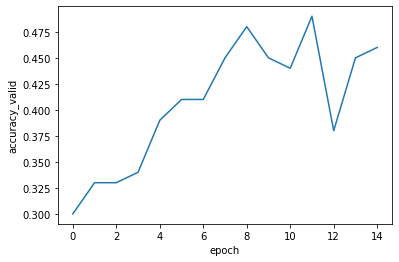

In [8]:
accuracy_valid = [0.30,0.33,0.33,0.34,0.39,0.41,0.41,0.45,0.48,0.45,0.44,0.49,0.38,0.45,0.46]

import matplotlib.pyplot as plt
plt.plot(accuracy_valid)
plt.ylabel('accuracy_valid')
plt.xlabel('epoch')
plt.show()


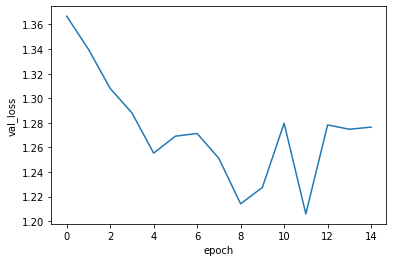

In [9]:
val_loss = [1.3667023380597432,1.3398761351903279,1.3079910278320312,1.288110613822937,1.2553701102733612,1.2691813707351685,1.2713744044303894,1.2510877052942913,1.214165210723877,1.2274719178676605,1.2797055045763652,1.2059479256470997,1.2783254981040955,1.2748095591862996,1.2765265901883442]

import matplotlib.pyplot as plt
plt.plot(val_loss)
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.show()

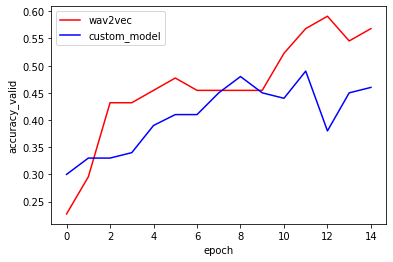

In [14]:
accuracy_valid_2 = [0.30,0.33,0.33,0.34,0.39,0.41,0.41,0.45,0.48,0.45,0.44,0.49,0.38,0.45,0.46]
accuracy_valid_1 = [0.227273,0.295455,0.431818,0.431818,0.454545,0.477273,0.454545,0.454545,0.454545,0.454545,0.522727,0.568182,0.590909,0.545455,0.568182]

import matplotlib.pyplot as plt
plt.plot(accuracy_valid_1, "r")
plt.plot(accuracy_valid_2, "b")
plt.legend(['wav2vec', 'custom_model'])
plt.ylabel('accuracy_valid')
plt.xlabel('epoch')
plt.show()
